In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



In [5]:
# Load the data 
data = pd.read_csv("Project Dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   MaritalStatus                5630 non-null   object 
 7   AgeGroup                     5630 non-null   int64  
 8   Gender                       5630 non-null   object 
 9   HourSpendOnApp               5375 non-null   float64
 10  OrderCount                   5372 non-null   float64
 11  OrderAmountHikeFromlastYear  5365 non-null   float64
 12  DaySinceLastOrder            5323 non-null   float64
 13  PreferedOrderCat  

Model: Logistic Regression
ROC-AUC Score: 0.6888416578108395
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       941
           1       0.78      0.40      0.53       185

    accuracy                           0.88      1126
   macro avg       0.84      0.69      0.73      1126
weighted avg       0.87      0.88      0.87      1126

Best Parameters: {'classifier__C': 10, 'classifier__solver': 'liblinear'}


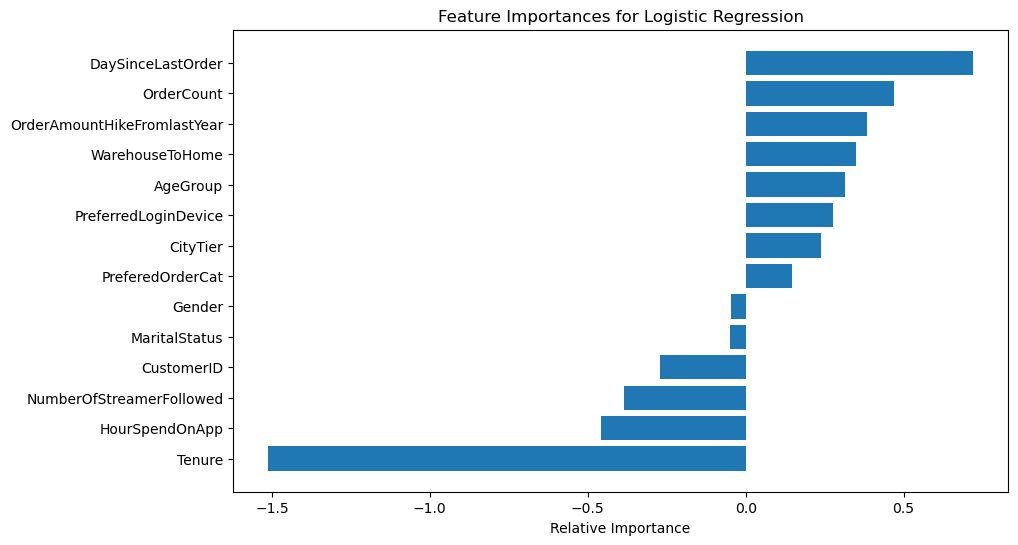

--------------------------------------------------------------------------------


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV


# Define the features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())]), 
         X.select_dtypes(include=['int64', 'float64']).columns),
        
        # ('cat', Pipeline(steps=[
        #     ('imputer', SimpleImputer(strategy='most_frequent')),
        #     ('onehot', OneHotEncoder(handle_unknown='ignore'))]), 
        #  X.select_dtypes(include=['object']).columns)
    ])

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# Define separate hyperparameter grids
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

rf_param_grid = {
    'classifier__n_estimators': [10, 50, 200, 300, 10000],
    'classifier__max_depth': [10, 20, 30]
}

svc_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid']
}

'''
svc_param_grid = {
    'classifier__C': [1, 10, 100],  # Reduced values
    'classifier__gamma': [0.01, 0.001],  # Reduced values
    'classifier__kernel': ['rbf']  # Focused on one kernel
}
'''

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate each model
for model_name, model in models.items():
    if model_name == 'Random Forest':
        param_grid = rf_param_grid
    elif model_name == 'Support Vector Machine':
        param_grid = svc_param_grid
    else:
        param_grid = lr_param_grid

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.set_params(classifier__random_state=42)
    
    cv = GridSearchCV(clf, param_grid, scoring='f1', cv=5)
    cv.fit(X_train, y_train)

    # Evaluate the best model on the test data
    y_pred = cv.predict(X_test)
    score = roc_auc_score(y_test, y_pred)

    print(f"Model: {model_name}")    
    print(f'ROC-AUC Score: {score}')
    print(classification_report(y_test, y_pred))
    print(f'Best Parameters: {cv.best_params_}')

    #Calculate and visualize feature importances

    best_model = cv.best_estimator_.named_steps['classifier']
    if model_name == 'Logistic Regression':
        importances = best_model.coef_[0]
    elif model_name == 'Random Forest':
        importances = best_model.feature_importances_
    elif model_name == 'Support Vector Machine':
        importances = np.abs(best_model.coef_[0])
    
    features = X.columns
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

    print("-" * 80)

Model: Random Forest
ROC-AUC Score: 0.8438205474337249
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       941
           1       0.97      0.69      0.81       185

    accuracy                           0.95      1126
   macro avg       0.96      0.84      0.89      1126
weighted avg       0.95      0.95      0.94      1126

Best Parameters: {'classifier__max_depth': 30, 'classifier__n_estimators': 10000}


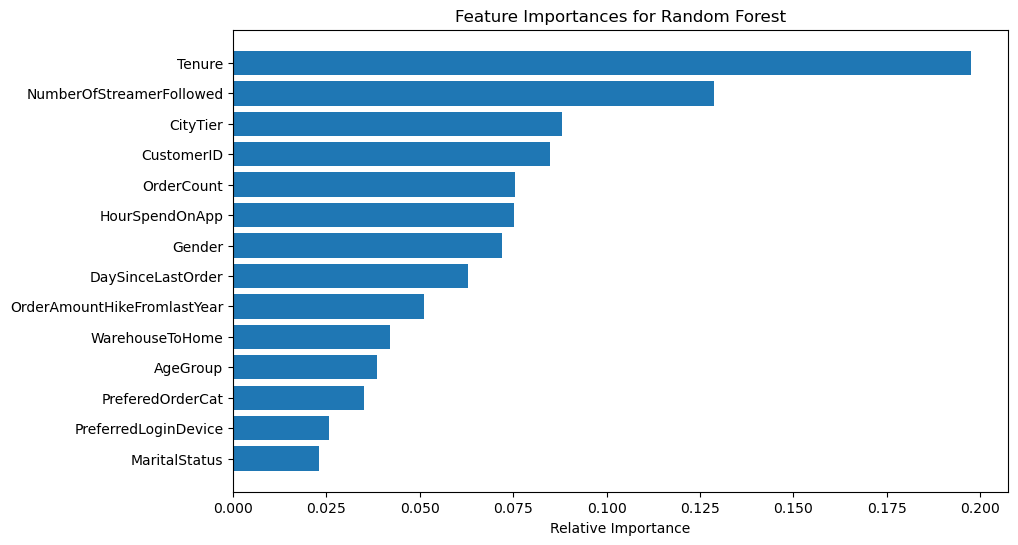

--------------------------------------------------------------------------------
Model: Support Vector Machine
ROC-AUC Score: 0.8304448976074906
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       941
           1       0.87      0.68      0.76       185

    accuracy                           0.93      1126
   macro avg       0.90      0.83      0.86      1126
weighted avg       0.93      0.93      0.93      1126

Best Parameters: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
--------------------------------------------------------------------------------


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Define the features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())]), 
         X.select_dtypes(include=['int64', 'float64']).columns),
    ])

# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42)
}

# Define separate hyperparameter grids
rf_param_grid = {
    'classifier__n_estimators': [10, 50, 200, 300, 10000],
    'classifier__max_depth': [10, 20, 30]
}

svc_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate each model
for model_name, model in models.items():
    if model_name == 'Random Forest':
        param_grid = rf_param_grid
    elif model_name == 'Support Vector Machine':
        param_grid = svc_param_grid

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    cv = GridSearchCV(clf, param_grid, scoring='f1', cv=5)
    cv.fit(X_train, y_train)

    # Evaluate the best model on the test data
    y_pred = cv.predict(X_test)
    score = roc_auc_score(y_test, y_pred)

    print(f"Model: {model_name}")    
    print(f'ROC-AUC Score: {score}')
    print(classification_report(y_test, y_pred))
    print(f'Best Parameters: {cv.best_params_}')

    # Calculate and visualize feature importances
    best_model = cv.best_estimator_.named_steps['classifier']
    if model_name == 'Random Forest':
        importances = best_model.feature_importances_
    elif model_name == 'Support Vector Machine' and cv.best_params_['classifier__kernel'] == 'linear':
        importances = np.abs(best_model.coef_[0])
    else:
        importances = None
    
    if importances is not None:
        features = X.columns
        indices = np.argsort(importances)
        
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances for {model_name}')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    print("-" * 80)

**Ordercat_df.csv**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   5630 non-null   int64  
 1   CustomerID                   5630 non-null   float64
 2   Churn                        5630 non-null   float64
 3   Tenure                       5630 non-null   float64
 4   PreferredLoginDevice         5630 non-null   float64
 5   CityTier                     5630 non-null   float64
 6   WarehouseToHome              5630 non-null   float64
 7   MaritalStatus                5630 non-null   float64
 8   AgeGroup                     5630 non-null   float64
 9   Gender                       5630 non-null   float64
 10  HourSpendOnApp               5630 non-null   float64
 11  OrderCount                   5630 non-null   float64
 12  OrderAmountHikeFromlastYear  5630 non-null   float64
 13  DaySinceLastOrder 

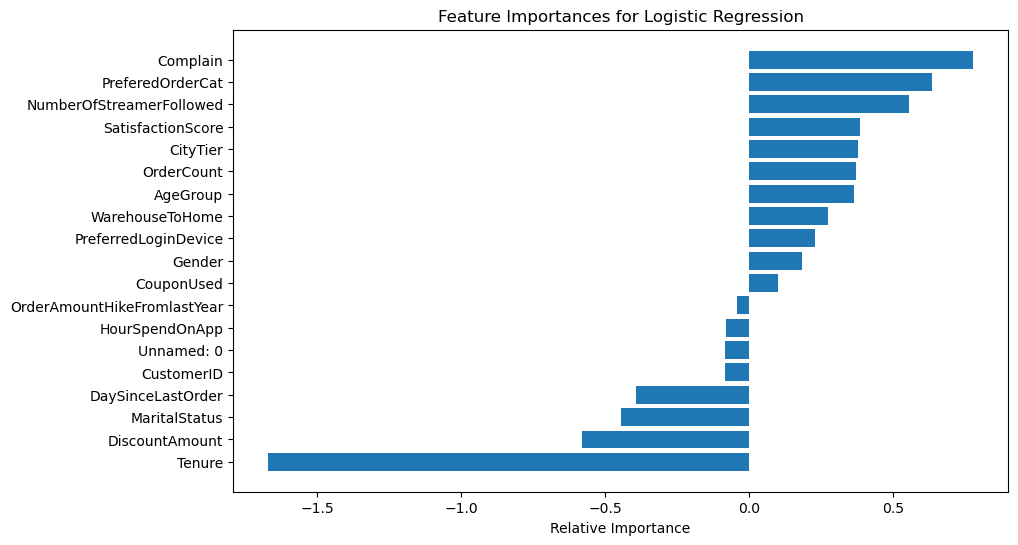

--------------------------------------------------------------------------------
Model: Random Forest
ROC-AUC Score: 0.8438205474337249
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       941
         1.0       0.97      0.69      0.81       185

    accuracy                           0.95      1126
   macro avg       0.96      0.84      0.89      1126
weighted avg       0.95      0.95      0.94      1126

Best Parameters: {'classifier__max_depth': 30, 'classifier__n_estimators': 10000}


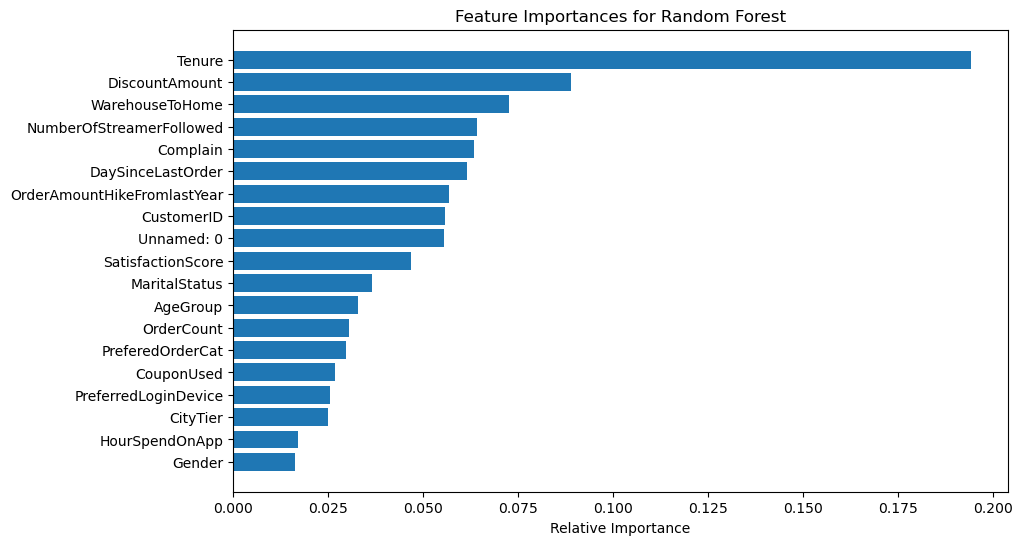

--------------------------------------------------------------------------------
Model: Support Vector Machine
ROC-AUC Score: 0.8784702875032313
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       941
         1.0       0.93      0.77      0.84       185

    accuracy                           0.95      1126
   macro avg       0.95      0.88      0.91      1126
weighted avg       0.95      0.95      0.95      1126

Best Parameters: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}


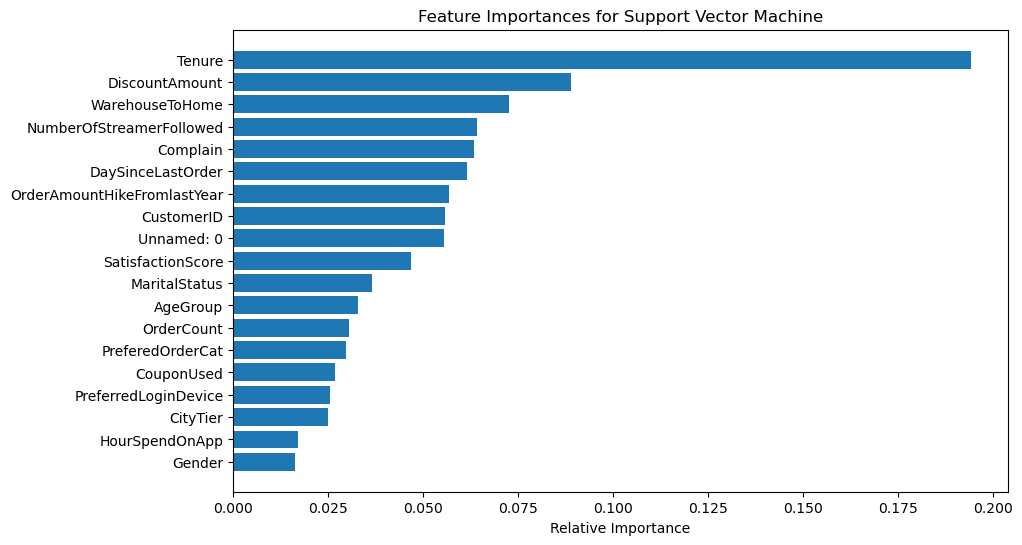

--------------------------------------------------------------------------------


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Load the data 
data = pd.read_csv("ordercat_df.csv")
data.info()

# Define the features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())]), 
         X.select_dtypes(include=['int64', 'float64']).columns),
    ])

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42)
}

# Define separate hyperparameter grids

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

rf_param_grid = {
    'classifier__n_estimators': [10, 50, 200, 300, 10000],
    'classifier__max_depth': [10, 20, 30]
}

svc_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate each model
for model_name, model in models.items():
    if model_name == 'Random Forest':
        param_grid = rf_param_grid
    elif model_name == 'Support Vector Machine':
        param_grid = svc_param_grid
    else:
        param_grid = lr_param_grid


    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.set_params(classifier__random_state=42)

    cv = GridSearchCV(clf, param_grid, scoring='f1', cv=5)
    cv.fit(X_train, y_train)

    # Evaluate the best model on the test data
    y_pred = cv.predict(X_test)
    score = roc_auc_score(y_test, y_pred)

    print(f"Model: {model_name}")    
    print(f'ROC-AUC Score: {score}')
    print(classification_report(y_test, y_pred))
    print(f'Best Parameters: {cv.best_params_}')

    # Calculate and visualize feature importances
    best_model = cv.best_estimator_.named_steps['classifier']
    if model_name == 'Random Forest':
        importances = best_model.feature_importances_
    elif model_name == 'Support Vector Machine' and cv.best_params_['classifier__kernel'] == 'linear':
        importances = np.abs(best_model.coef_[0])
    elif model_name == 'Logistic Regression':
        importances = best_model.coef_[0]
    
    if importances is not None:
        features = X.columns
        indices = np.argsort(importances)
        
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances for {model_name}')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    print("-" * 80)

Model: Logistic Regression
ROC-AUC Score: 0.7353189533848408
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       941
         1.0       0.82      0.49      0.61       185

    accuracy                           0.90      1126
   macro avg       0.86      0.74      0.78      1126
weighted avg       0.89      0.90      0.89      1126

Best Parameters: {'classifier__C': 10, 'classifier__solver': 'liblinear'}


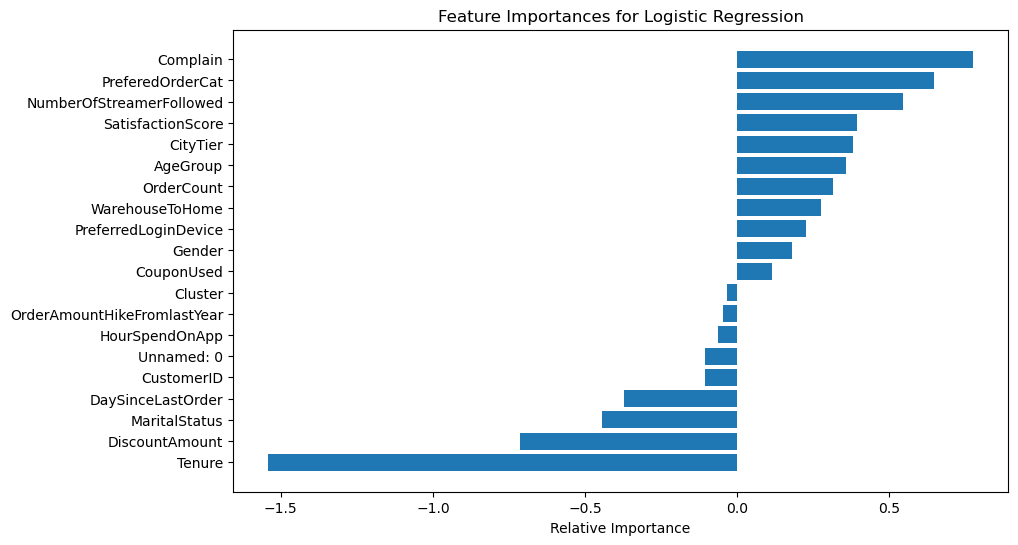

--------------------------------------------------------------------------------
Model: Random Forest
ROC-AUC Score: 0.8313697331763218
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       941
         1.0       0.98      0.66      0.79       185

    accuracy                           0.94      1126
   macro avg       0.96      0.83      0.88      1126
weighted avg       0.95      0.94      0.94      1126

Best Parameters: {'classifier__max_depth': 30, 'classifier__n_estimators': 10000}


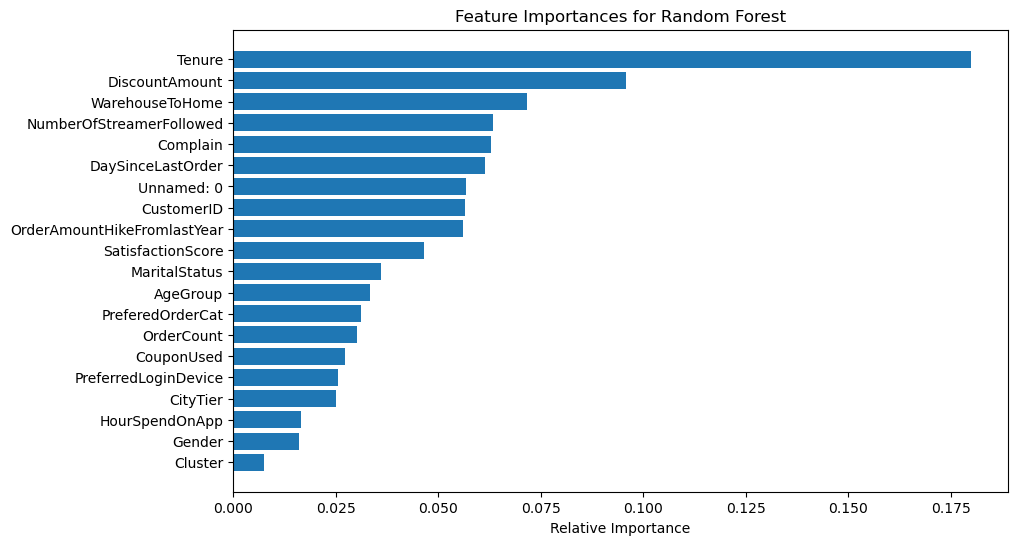

--------------------------------------------------------------------------------
Model: Support Vector Machine
ROC-AUC Score: 0.8342562541287303
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       941
         1.0       0.85      0.69      0.76       185

    accuracy                           0.93      1126
   macro avg       0.90      0.83      0.86      1126
weighted avg       0.93      0.93      0.93      1126

Best Parameters: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}


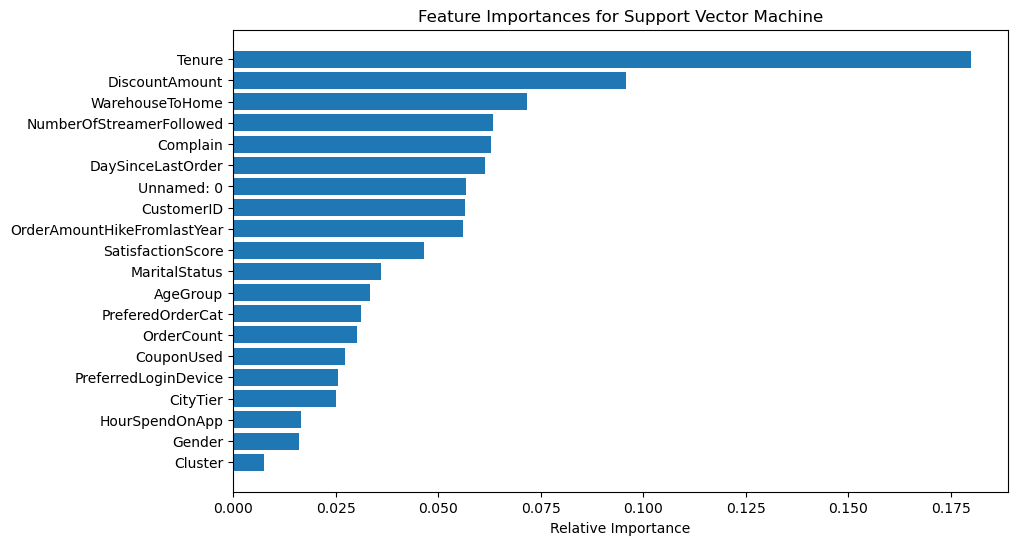

--------------------------------------------------------------------------------


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Load the data 
data = pd.read_csv("pca_df.csv")

# Define the features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())]), 
         X.select_dtypes(include=['int64', 'float64']).columns),
    ])

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42)
}

# Define separate hyperparameter grids

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

rf_param_grid = {
    'classifier__n_estimators': [10, 50, 200, 300, 10000],
    'classifier__max_depth': [10, 20, 30]
}

svc_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate each model
for model_name, model in models.items():
    if model_name == 'Random Forest':
        param_grid = rf_param_grid
    elif model_name == 'Support Vector Machine':
        param_grid = svc_param_grid
    else:
        param_grid = lr_param_grid


    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.set_params(classifier__random_state=42)

    cv = GridSearchCV(clf, param_grid, scoring='f1', cv=5)
    cv.fit(X_train, y_train)

    # Evaluate the best model on the test data
    y_pred = cv.predict(X_test)
    score = roc_auc_score(y_test, y_pred)

    print(f"Model: {model_name}")    
    print(f'ROC-AUC Score: {score}')
    print(classification_report(y_test, y_pred))
    print(f'Best Parameters: {cv.best_params_}')

    # Calculate and visualize feature importances
    best_model = cv.best_estimator_.named_steps['classifier']
    if model_name == 'Random Forest':
        importances = best_model.feature_importances_
    elif model_name == 'Support Vector Machine' and cv.best_params_['classifier__kernel'] == 'linear':
        importances = np.abs(best_model.coef_[0])
    elif model_name == 'Logistic Regression':
        importances = best_model.coef_[0]
    
    if importances is not None:
        features = X.columns
        indices = np.argsort(importances)
        
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances for {model_name}')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    print("-" * 80)